# RANSAC算法的核心思想
它的核心思想是不断随机采样少量点去拟合一个模型。  
用其他数据点判断这个模型是否足够好（标准是有多少个点满足这个模型）。  
如果这个模型足够好的话那么用满足这个模型的那些点去重新拟合一个新的模型。  

简化的RANSAC：用于去除噪声点  
每次最少采样点数m（一条直线最少需要m=2个点），判断其他数据点与模型的误差是否大于e（认为是离群点outliers），反之则是内点。  
设置足够好的模型的最少内点数n（如果内点数大于等于n就认为这个模型足够好了，可以终止迭代）  
最大迭代次数K(如果K次迭代内都没有找到合格模型则停止)。

### 正规的RANSAC算法流程
1. 随机抽样（Sample）  
从原始数据集中**随机**、非重复地选择一个最小的子集（通常称为样本）。  
这个子集的大小 s 是估计模型所需的最少数据点数。例如：  
拟合一条直线需要 2 个点 (s=2)。  
估计一个单应性矩阵需要 4 个点 (s=4)。  
估计一个基础矩阵需要 8 个点 (s=8)。  
2. 模型拟合（Model Fitting）  
使用这个**随机抽样**得到的子集，拟合出一个模型。这个模型是临时的，我们称之为“假设模型”（hypothesized model）。  
3. 统计内点（Inlier Counting）  
遍历整个原始数据集中的所有数据点。  
对于每个数据点，计算它与假设模型的误差（或距离）。  
如果误差小于一个预先设定的阈值 t，则认为这个数据点是该假设模型的内点。  
统计出本次迭代中内点的总数。  
4. 评估和更新（Evaluation and Update）  
比较当前假设模型的内点数量，与之前所有迭代中得到的最大内点数量 d。  
**如果当前模型的内点数量大于 d，则更新最优模型**：  
将当前模型设为最优模型。  
将当前的内点集合保存为最优内点集合。  
更新 d 为当前的内点数量。  
5. 重复迭代（Repetition）  
重复上述步骤 N 次。N 是一个预先设定的迭代次数。  
6. 最终模型（Final Model）  
在 N 次迭代后，你将得到一个包含最多内点的最优模型。  
通常，为了得到更精确的结果，会使用这个最优内点集合中的所有数据点，重新拟合一次最终的模型。这个最终模型通常比迭代过程中得到的模型更稳定、更精确。  

一般：$n-m>5，K=2p^{(-m)}$,其中p是指随机的一个数据点落在拟合模型范围内的概率（这个概率是由最大容忍误差决定的

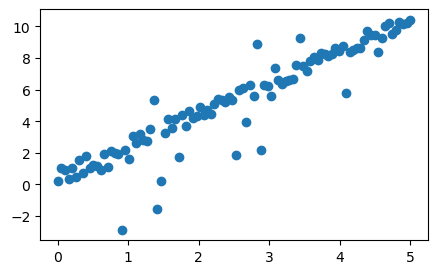

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def gen_data():
    x = np.linspace(0, 5, 100)
    y = 2*x + np.random.rand(x.shape[0])
    # 制造离群点
    outlier_num = 20
    for _ in range(outlier_num):
        y[np.random.randint(100)] += 10*(np.random.rand()-0.5)
    return x, y
x, y = gen_data()
plt.figure(figsize=(5, 3))
plt.scatter(x,y)
plt.show()

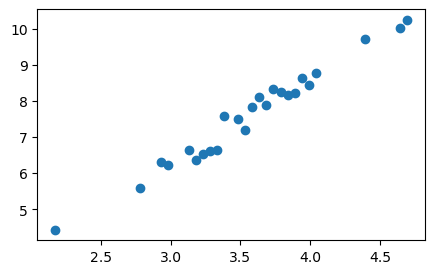

In [27]:
def f_two_point_line(x1,y1,x2,y2):
    '''
    两点法确立一个直线，返回所拟合的直线斜率和截距
    '''
    k = (y2-y1)/(x2-x1)
    b = y1 - k*x1
    return k,b

def RANSAC_filte_outlier(x,y):
    '''
    RANSAC算法去除离群点
    '''
    m = 2 #确定一条直线最少每次需要取2个点
    e = 0.5 # 只要某个点离所拟合的直线距离小于0.5那么认为不是离群点
    n = 20 # 只要某个拟合的直线能够让20个点足够接近它那么认为当前直线是比较理想的直线
    K = int(2 * (1/5)**(-m)) # 最大迭代次数，这个可以随便设置的
    for _ in range(K):
        # 1. 随机选m个点来拟合一条直线这里是两个点所以用两点法确定一条直线
        p1_index = np.random.randint(x.shape[0])
        p2_index = np.random.randint(x.shape[0])

        # 两点法确定一条直线
        p1_x = x[p1_index]
        p1_y = y[p1_index]
        p2_x = x[p2_index]
        p2_y = y[p2_index]
        k, b = f_two_point_line(p1_x, p1_y, p2_x, p2_y)
        y_predict = k * x + b

        inliner_bool = np.abs(y - y_predict) < e  # 判断哪些点是inlier
        if np.sum(inliner_bool) >= n:
            return x[inliner_bool], y[inliner_bool]  # 如果有足够多的点满足这个模型那么就返回这个模型
    return None, None  # 如果没有找到合适的模型那么返回None

x_filted, y_filted = RANSAC_filte_outlier(x, y)
plt.figure(figsize=(5, 3))
plt.scatter(x_filted,y_filted)
plt.show()


##### 可以看到上图许多噪声点已经被去除。拟合这条曲线可以用最小二乘法求解。